<a href="https://colab.research.google.com/github/sohamtalukdar/Segmentation-of-Kidneys-in-MRI/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel --upgrade
!pip install keras-adabound
from keras_adabound import AdaBound
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import nibabel as nib
from nibabel.processing import conform
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from keras import backend as K
from PIL import ImageOps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 4.1 MB/s 
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6609 sha256=79026ca302d9d8f2def0201fb390509200f6579685dd13386d4a467d903b72ca
  Stored in directory: /root/.cache/pip/wheels/3e/bf/39/3d95847ef12aa58c15a6cc7a20f4f21ea39fcd52793e1beea0
Successfully built keras-adabound


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
"""Shamelessly taken from Alex Daniel - will cite properly!"""

def rescale(data, black=None, white=None):
    if black is None:
        black = np.mean(data) - 0.5 * np.std(data)
        if black < data.min():
            black = data.min()
    if white is None:
        white = np.mean(data) + 4 * np.std(data)
        if white > data.max():
            white = data.max()
    data = np.clip(data, black, white) - black
    data = data / (white - black)
    return data

def normalise_image(image, affine):

    image = rescale(image)
    img = nib.Nifti1Image(image, affine)
    zoom = img.header.get_zooms()
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, zoom[-1] * 0.998),
                  orientation='LIP')
    image = img.get_fdata()
    image = resize(image, (256, 256, image.shape[2]))
    zoom = img.header.get_zooms()
    return image
  
def normalise_mask(mask, affine):

    img = nib.Nifti1Image(mask, affine)
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, img.header.get_zooms()[-1] *
                              0.998),
                  orientation='LIP')
    mask = img.get_fdata()
    mask = resize(mask, (256, 256, mask.shape[2]))
    mask = np.round(mask)
    return mask

In [4]:
ground_truths = []
base_scans = []
dir = '/content/drive/MyDrive/ColabNotebooks/UNet/'
for f in sorted(os.listdir(dir + 'GroundTruth/')):
  image = nib.load(dir + 'GroundTruth/' + f)
  ground_truths.append(image)
for f in sorted(os.listdir(dir + 'Masks_T1/')):
  image = nib.load(dir + 'Masks_T1/'+ f)
  base_scans.append(image)
print(ground_truths[1].header.get_data_shape())


(256, 256, 17)


In [5]:
gt_arrays = []
gt_affine = []
base_arrays = []
base_affine = []
for img in ground_truths:
  affine = img.affine
  gt_voxels = img.get_fdata()
  normalised = normalise_mask(gt_voxels, affine)
  gt_arrays.append(normalised)
for img in base_scans:
  affine = img.affine
  base_voxels = img.get_fdata()
  normalised = normalise_image(base_voxels, affine)
  base_arrays.append(base_voxels)
pairs = zip(gt_arrays, base_arrays)

print(gt_arrays[1].shape)
print(len(gt_arrays), len(gt_affine))
print(type(base_arrays[2]))




(256, 256, 17)
10 0
<class 'numpy.ndarray'>


In [6]:
x_series = pd.Series(base_arrays)
y_series = pd.Series(gt_arrays)

#also courtesy of Alex Daniel

def tf_arrays(series):
    data = np.concatenate(series, 2)
    data = np.swapaxes(data, 0, 2)
    data = np.swapaxes(data, 1, 2)
    data = np.expand_dims(data, 3)
    return data

x_data = tf_arrays(x_series)
y_data = tf_arrays(y_series)
"""
for img in base_arrays:
  for i in range(0,17):
    x_images.append(img[:,:,i,np.newaxis])
for img in gt_arrays:
  for i in range(0,17):
    y_images.append(img[:,:,i,np.newaxis])
"""

print(len(x_data), len(y_data))
print(x_data[1].shape, y_data[1].shape)


"""
fig, ax = plt.subplots(2)
ax[0].imshow(x_images[46])
ax[1].imshow(y_images[46])
plt.show()
"""

170 170
(256, 256, 1) (256, 256, 1)


'\nfig, ax = plt.subplots(2)\nax[0].imshow(x_images[46])\nax[1].imshow(y_images[46])\nplt.show()\n'

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                     test_size = 0.3)

In [ ]:
! pip install segmentation_models_3D

In [25]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=3)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [26]:
### UNET

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2



def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1


def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, (1,1), padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model



In [27]:
input_size = (256, 256,1)
model = U_Net(input_size)

In [33]:
#optimizer - Adam
model.compile(optimizer= Adam(learning_rate = 0.0001), 
              loss=dice_coef_9cat_loss,
              metrics = dice_coef_9cat
              )

# Train the model, doing validation at the end of each epoch.
result = model.fit(x=x_train, 
                   y=y_train, 
                   batch_size=12, 
                   epochs=60, 
                   validation_data=(x_valid, y_valid), 
                   steps_per_epoch=len(x_train)//2 
                   )

Epoch 1/60
59/59 [==============================] - 63s 886ms/step - loss: 0.2036 - dice_coef_9cat: 0.7963 - val_loss: 0.2645 - val_dice_coef_9cat: 0.7412
Epoch 2/60
59/59 [==============================] - 42s 716ms/step - loss: 0.1808 - dice_coef_9cat: 0.8194 - val_loss: 0.2668 - val_dice_coef_9cat: 0.7415
Epoch 3/60
59/59 [==============================] - 42s 705ms/step - loss: 0.1647 - dice_coef_9cat: 0.8353 - val_loss: 0.2787 - val_dice_coef_9cat: 0.7312
Epoch 4/60
59/59 [==============================] - 42s 709ms/step - loss: 0.1515 - dice_coef_9cat: 0.8485 - val_loss: 0.2852 - val_dice_coef_9cat: 0.7230
Epoch 5/60
59/59 [==============================] - 42s 706ms/step - loss: 0.1557 - dice_coef_9cat: 0.8445 - val_loss: 0.2704 - val_dice_coef_9cat: 0.7344
Epoch 6/60
59/59 [==============================] - 42s 716ms/step - loss: 0.1250 - dice_coef_9cat: 0.8750 - val_loss: 0.2548 - val_dice_coef_9cat: 0.7517
Epoch 7/60
59/59 [==============================] - 42s 710ms/step - l

59/59 [==============================] - 8s 123ms/step - loss: 0.0882 - dice_coef_9cat: 0.9118 - val_loss: 0.2909 - val_dice_coef_9cat: 0.7204


2/2 [==============================] - 1s 337ms/step - loss: 0.3141 - dice_coef_9cat: 0.6825


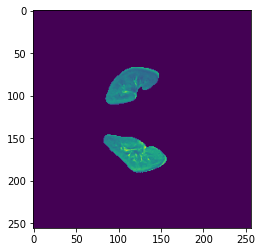

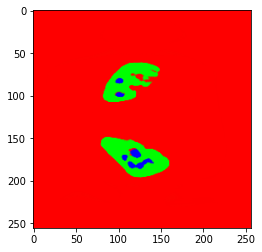

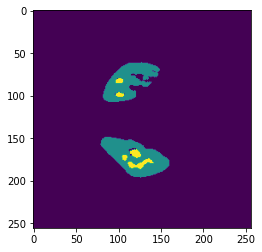

In [32]:
"model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_train)
plt.show()
#FOR T2 - 20,14,12,11,6,5,3,2( 12 ): 2,3,4,8
#FOR T1 - 20,18,16,12,11,10,7,6,5,4
i = 12
plt.imshow(np.squeeze(x_train[i]))
plt.show()
# plt.imshow(np.squeeze(y_train[i]))
# plt.show()
plt.imshow(np.squeeze(predicted_masks[i]))
plt.show()


def display_mask(j):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(predicted_masks[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    #display(img)
    plt.imshow(np.squeeze(mask))
    plt.show()

display_mask(predicted_masks[i])
